# National

In [6]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# =====================================================
# 1. FILES & BASE DATA
# =====================================================

analysis_file = "National_Schools_with_AdvancedSTEM_Expanded.csv"
school_chars_file = "school chars.csv"    # same file you used earlier

# Load analysis dataset
df = pd.read_csv(analysis_file, dtype=str)
df["NCESSCH"] = df["NCESSCH"].astype(str)

print("Loaded analysis data:", df.shape)

# -----------------------------------------------------
# 2. MERGE STATE & DISTRICT INFO (ST / LEAID)
# -----------------------------------------------------

sch_chars = pd.read_csv(school_chars_file, dtype=str)
if "NCESSCH" not in sch_chars.columns:
    raise ValueError("Expected NCESSCH column in school chars.csv")

sch_chars["NCESSCH"] = sch_chars["NCESSCH"].astype(str)

# Pick state column
if "ST" in sch_chars.columns:
    state_col = "ST"
elif "STATENAME" in sch_chars.columns:
    state_col = "STATENAME"
else:
    raise ValueError("Expected ST or STATENAME in school chars.csv")

if "LEAID" not in sch_chars.columns:
    raise ValueError("Expected LEAID in school chars.csv")

sch_chars_small = sch_chars[["NCESSCH", state_col, "LEAID"]].drop_duplicates("NCESSCH")

df = df.merge(sch_chars_small, on="NCESSCH", how="left")
df.rename(columns={state_col: "ST"}, inplace=True)

print("After merging ST and LEAID:", df.shape)

# =====================================================
# 3. CONSTRUCT KEY VARIABLES
# =====================================================

# --- HOLC treatment variables ---
df["grade"] = df["grade"].astype(str).str.strip().str.upper()
df["Redline_CD"] = df["grade"].isin(["C", "D"]).astype(int)
df["grade_cat"] = pd.Categorical(df["grade"], categories=["A", "B", "C", "D"])

# --- STEM outcomes ---

# Make sure Has_* exist
for col in ["Has_Calc", "Has_CS", "Has_Physics"]:
    if col not in df.columns:
        df[col] = "No"

df["Any_STEM"] = (
    (df["Has_Calc"] == "Yes") |
    (df["Has_CS"] == "Yes") |
    (df["Has_Physics"] == "Yes")
).astype(int)

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

df["Total_STEM_Classes"] = (
    df["Num_Calc_Classes"] +
    df["Num_CS_Classes"] +
    df["Num_Physics_Classes"]
)

# --- Control variables ---

# Separate magnet + charter flags from status columns
for status_col in ["SCH_STATUS_MAGNET", "SCH_STATUS_CHARTER"]:
    if status_col not in df.columns:
        df[status_col] = np.nan

def status_to_flag(series):
    pos = {"YES", "Y", "1", "TRUE", "T"}
    return series.astype(str).str.strip().str.upper().isin(pos).astype(int)

df["MAGNET_FLAG"] = status_to_flag(df["SCH_STATUS_MAGNET"])
df["CHARTER_FLAG"] = status_to_flag(df["SCH_STATUS_CHARTER"])

# PCT_CERTIFIED_FTE numeric
if "PCT_CERTIFIED_FTE" not in df.columns:
    df["PCT_CERTIFIED_FTE"] = np.nan
df["PCT_CERTIFIED_FTE"] = pd.to_numeric(df["PCT_CERTIFIED_FTE"], errors="coerce")

# TITLE1_FLAG numeric
if "TITLE1_FLAG" not in df.columns:
    df["TITLE1_FLAG"] = np.nan
df["TITLE1_FLAG"] = pd.to_numeric(df["TITLE1_FLAG"], errors="coerce")

# Ensure ST and LEAID are strings (for fixed effects & clustering)
df["ST"] = df["ST"].astype(str)
df["LEAID"] = df["LEAID"].astype(str)

# =====================================================
# 4. REGRESSION SAMPLE
# =====================================================

needed_cols = [
    "Any_STEM", "Total_STEM_Classes",
    "Redline_CD", "grade_cat",
    "MAGNET_FLAG", "CHARTER_FLAG",
    "PCT_CERTIFIED_FTE", "TITLE1_FLAG",
    "ST", "LEAID"
]

reg_df = df[needed_cols].copy()

# Drop rows with missing in key vars
reg_df = reg_df.dropna(
    subset=[
        "Any_STEM",
        "Total_STEM_Classes",
        "PCT_CERTIFIED_FTE",
        "TITLE1_FLAG",
        "ST",
        "LEAID",
        "grade_cat"
    ]
)

# Coerce numeric types
reg_df["Any_STEM"] = reg_df["Any_STEM"].astype(int)
reg_df["Total_STEM_Classes"] = pd.to_numeric(
    reg_df["Total_STEM_Classes"], errors="coerce"
).fillna(0)

reg_df["Redline_CD"] = reg_df["Redline_CD"].astype(int)
reg_df["MAGNET_FLAG"] = reg_df["MAGNET_FLAG"].astype(int)
reg_df["CHARTER_FLAG"] = reg_df["CHARTER_FLAG"].astype(int)
reg_df["TITLE1_FLAG"] = reg_df["TITLE1_FLAG"].astype(float)

print("Final regression sample:", reg_df.shape)

# =====================================================
# 5. HELPER: OLS WITH CLUSTERED SE BY LEAID
# =====================================================

def fit_ols_cluster(formula, data, cluster_var, model_name):
    model = smf.ols(formula, data=data)
    res = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": data[cluster_var]}
    )
    params = res.params
    bse = res.bse
    pvals = res.pvalues
    tvals = res.tvalues

    out = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "std_err": bse.values,
        "t_value": tvals.values,
        "p_value": pvals.values,
        "model": model_name
    })
    return res, out

results_list = []

# =====================================================
# 6. LPM MODELS (OLS) — Any_STEM
# =====================================================

# (1) Any_STEM ~ Redline_CD + controls + state & district FE
formula_lpm_bin = """
Any_STEM ~ Redline_CD
           + MAGNET_FLAG
           + CHARTER_FLAG
           + PCT_CERTIFIED_FTE
           + TITLE1_FLAG
           
"""

lpm_bin_res, lpm_bin_tidy = fit_ols_cluster(
    formula_lpm_bin,
    data=reg_df,
    cluster_var="LEAID",
    model_name="LPM_AnySTEM_BinaryRedline"
)
results_list.append(lpm_bin_tidy)
print("\n=== LPM: Any_STEM ~ Redline_CD + controls + ST & LEAID FE ===")
print(lpm_bin_res.summary())

# (2) Any_STEM ~ full HOLC grade dummies + controls + FE
formula_lpm_cat = """
Any_STEM ~ C(grade_cat, Treatment('A'))
           + MAGNET_FLAG
           + CHARTER_FLAG
           + PCT_CERTIFIED_FTE
           + TITLE1_FLAG
           
"""

lpm_cat_res, lpm_cat_tidy = fit_ols_cluster(
    formula_lpm_cat,
    data=reg_df,
    cluster_var="LEAID",
    model_name="LPM_AnySTEM_GradeCat"
)
results_list.append(lpm_cat_tidy)
print("\n=== LPM: Any_STEM ~ HOLC grade dummies + controls + ST & LEAID FE ===")
print(lpm_cat_res.summary())

# =====================================================
# 7. LPM MODELS (OLS) — Total_STEM_Classes
# =====================================================

# (3) Total_STEM_Classes ~ Redline_CD + controls + FE
formula_lpm_tot_bin = """
Total_STEM_Classes ~ Redline_CD
                     + MAGNET_FLAG
                     + CHARTER_FLAG
                     + PCT_CERTIFIED_FTE
                     + TITLE1_FLAG
                     
"""

lpm_tot_bin_res, lpm_tot_bin_tidy = fit_ols_cluster(
    formula_lpm_tot_bin,
    data=reg_df,
    cluster_var="LEAID",
    model_name="LPM_TotalSTEM_BinaryRedline"
)
results_list.append(lpm_tot_bin_tidy)
print("\n=== LPM: Total_STEM_Classes ~ Redline_CD + controls + ST & LEAID FE ===")
print(lpm_tot_bin_res.summary())

# (4) Total_STEM_Classes ~ full HOLC grade dummies + controls + FE
formula_lpm_tot_cat = """
Total_STEM_Classes ~ C(grade_cat, Treatment('A'))
                     + MAGNET_FLAG
                     + CHARTER_FLAG
                     + PCT_CERTIFIED_FTE
                     + TITLE1_FLAG
                     
"""

lpm_tot_cat_res, lpm_tot_cat_tidy = fit_ols_cluster(
    formula_lpm_tot_cat,
    data=reg_df,
    cluster_var="LEAID",
    model_name="LPM_TotalSTEM_GradeCat"
)
results_list.append(lpm_tot_cat_tidy)
print("\n=== LPM: Total_STEM_Classes ~ HOLC grade dummies + controls + ST & LEAID FE ===")
print(lpm_tot_cat_res.summary())

# =====================================================
# 8. EXPORT TIDY RESULTS
# =====================================================

all_results = pd.concat(results_list, ignore_index=True)
out_csv = "Regression_Results_LPM.csv"
all_results.to_csv(out_csv, index=False)

print("\nSaved LPM regression results to:", os.path.abspath(out_csv))


Loaded analysis data: (1767, 19)
After merging ST and LEAID: (1767, 21)
Final regression sample: (377, 10)

=== LPM: Any_STEM ~ Redline_CD + controls + ST & LEAID FE ===
                            OLS Regression Results                            
Dep. Variable:               Any_STEM   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.869
Date:                Sun, 16 Nov 2025   Prob (F-statistic):            0.00212
Time:                        15:55:49   Log-Likelihood:                -227.09
No. Observations:                 377   AIC:                             466.2
Df Residuals:                     371   BIC:                             489.8
Df Model:                           5                                         
Covariance Type:              cluster                                         
                        coef    std err 

In [9]:
import pandas as pd
import numpy as np
import os

# ===== Load your regression results from earlier =====
df = pd.read_csv("Regression_Results_LPM.csv")  # change filename if needed

# ===== APA formatting helpers =====
def format_p(p):
    if p < 0.001:
        return "< .001"
    elif p < 0.01:
        return f"{p:.3f}**"
    elif p < 0.05:
        return f"{p:.3f}*"
    else:
        return f"{p:.3f}"

def format_coef(coef, se):
    return f"{coef:.3f} ({se:.3f})"

# ===== Create output directory for APA tables =====
out_dir = "apa_tables"
os.makedirs(out_dir, exist_ok=True)

apa_tables = {}

for model in df['model'].unique():
    sub = df[df['model'] == model].copy()

    # Create APA columns
    sub["Coef (SE)"] = [
        format_coef(c, s) for c, s in zip(sub["coef"], sub["std_err"])
    ]
    sub["p"] = sub["p_value"].apply(format_p)

    # Select clean APA-style columns
    apa = sub[["term", "Coef (SE)", "p"]]

    # Save CSV
    csv_path = os.path.join(out_dir, f"APA_{model}.csv")
    apa.to_csv(csv_path, index=False)

    # Save Markdown version (great for your paper)
    md_path = os.path.join(out_dir, f"APA_{model}.md")
    apa.to_markdown(md_path, index=False)

    print(f"Saved APA table for {model} → {csv_path}")

print("\nAll APA tables saved in folder:", os.path.abspath(out_dir))


Saved APA table for LPM_AnySTEM_BinaryRedline → apa_tables/APA_LPM_AnySTEM_BinaryRedline.csv
Saved APA table for LPM_AnySTEM_GradeCat → apa_tables/APA_LPM_AnySTEM_GradeCat.csv
Saved APA table for LPM_TotalSTEM_BinaryRedline → apa_tables/APA_LPM_TotalSTEM_BinaryRedline.csv
Saved APA table for LPM_TotalSTEM_GradeCat → apa_tables/APA_LPM_TotalSTEM_GradeCat.csv

All APA tables saved in folder: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/apa_tables


## LA Regressions

In [11]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# =========================
# 1. LOAD DATA
# =========================

# LA schools that are in HOLC buffers
la_file = "LA_Schools_with_AdvancedSTEM.csv"
la_schools = pd.read_csv(la_file, dtype=str)

# National dataset with controls + STEM + Title I etc.
nat_file = "National_Schools_with_AdvancedSTEM_Expanded.csv"
nat = pd.read_csv(nat_file, dtype=str)

# Ensure NCESSCH exists
la_schools["NCESSCH"] = la_schools["NCESSCH"].astype(str)
nat["NCESSCH"] = nat["NCESSCH"].astype(str)

# =========================
# 2. MERGE LA LIST → NATIONAL DATA
# =========================

la_ids = la_schools[["NCESSCH"]].drop_duplicates()
df = la_ids.merge(nat, on="NCESSCH", how="left")

print(f"LA matched schools: {len(df)}")

# =========================
# 3. CLEAN VARIABLES
# =========================

# HOLC GRADE
df["grade"] = df["grade"].astype(str).str.strip().str.upper()
valid_grades = ["A", "B", "C", "D"]

df = df[df["grade"].isin(valid_grades)].copy()
df["grade_cat"] = pd.Categorical(df["grade"], categories=["A", "B", "C", "D"], ordered=True)

# BINARY REDLINE: A/B = 0, C/D = 1
df["Redline_CD"] = df["grade"].isin(["C", "D"]).astype(int)

# STEM COUNTS
for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# STEM INDICATORS
for subj, cnt in [
    ("Has_Calc", "Num_Calc_Classes"),
    ("Has_CS", "Num_CS_Classes"),
    ("Has_Physics", "Num_Physics_Classes"),
]:
    df[subj] = df[subj].fillna("No")
    df[subj + "_bin"] = df[subj].map({"Yes": 1, "No": 0})

# OUTCOME: Any STEM offered
df["Any_STEM"] = (
    df["Has_Calc_bin"] | df["Has_CS_bin"] | df["Has_Physics_bin"]
).astype(int)

# OUTCOME: Total STEM classes
df["Total_STEM_Classes"] = (
    df["Num_Calc_Classes"] + df["Num_CS_Classes"] + df["Num_Physics_Classes"]
)

# CONTROLS
def make_flag(col):
    return col.astype(str).str.strip().str.upper().map(
        {"YES": 1, "NO": 0, "1": 1, "0": 0}
    ).fillna(0).astype(int)

if "MAGNET_FLAG" in df.columns:
    df["MAGNET_FLAG"] = make_flag(df["MAGNET_FLAG"])
else:
    df["MAGNET_FLAG"] = 0

if "CHARTER_FLAG" in df.columns:
    df["CHARTER_FLAG"] = make_flag(df["CHARTER_FLAG"])
else:
    df["CHARTER_FLAG"] = 0

if "TITLE1_FLAG" in df.columns:
    df["TITLE1_FLAG"] = make_flag(df["TITLE1_FLAG"])
else:
    df["TITLE1_FLAG"] = 0

df["PCT_CERTIFIED_FTE"] = pd.to_numeric(df["PCT_CERTIFIED_FTE"], errors="coerce")

reg_df = df.dropna(subset=["Any_STEM", "Total_STEM_Classes", "Redline_CD"])

print("Final LA sample:", len(reg_df))

# =========================
# 4. HELPER FUNCTION: OLS LPM WITH HC3 ROBUST SE
# =========================

def run_lpm(formula, data, name):
    model = smf.ols(formula, data=data)
    res = model.fit(cov_type="HC3")  # HC3 robust SE
    tidy = pd.DataFrame({
        "term": res.params.index,
        "coef": res.params.values,
        "std_err": res.bse.values,
        "t_value": res.tvalues.values,
        "p_value": res.pvalues.values,
        "model": name
    })
    print(f"\n===== {name} =====")
    print(res.summary())
    return res, tidy

results = []

# =========================
# 5. RUN LA REGRESSIONS (NO CLUSTERING)
# =========================

# 5.1 Any STEM (binary) using Redline_CD
formula1 = """
Any_STEM ~ Redline_CD
           + MAGNET_FLAG
           + CHARTER_FLAG
           + PCT_CERTIFIED_FTE
           + TITLE1_FLAG
"""
res1, tidy1 = run_lpm(formula1, reg_df, "LA_LPM_AnySTEM_BinaryRedline")
results.append(tidy1)

# 5.2 Any STEM using categorical HOLC grade
formula2 = """
Any_STEM ~ C(grade_cat, Treatment('A'))
           + MAGNET_FLAG
           + CHARTER_FLAG
           + PCT_CERTIFIED_FTE
           + TITLE1_FLAG
"""
res2, tidy2 = run_lpm(formula2, reg_df, "LA_LPM_AnySTEM_GradeCat")
results.append(tidy2)

# 5.3 Total STEM using Redline_CD
formula3 = """
Total_STEM_Classes ~ Redline_CD
                     + MAGNET_FLAG
                     + CHARTER_FLAG
                     + PCT_CERTIFIED_FTE
                     + TITLE1_FLAG
"""
res3, tidy3 = run_lpm(formula3, reg_df, "LA_LPM_TotalSTEM_BinaryRedline")
results.append(tidy3)

# 5.4 Total STEM using categorical HOLC grade
formula4 = """
Total_STEM_Classes ~ C(grade_cat, Treatment('A'))
                     + MAGNET_FLAG
                     + CHARTER_FLAG
                     + PCT_CERTIFIED_FTE
                     + TITLE1_FLAG
"""
res4, tidy4 = run_lpm(formula4, reg_df, "LA_LPM_TotalSTEM_GradeCat")
results.append(tidy4)

# =========================
# 6. SAVE COMBINED RESULTS
# =========================

la_results = pd.concat(results, ignore_index=True)
la_results.to_csv("LA_Regression_Results_LPM.csv", index=False)
print("\nSaved → LA_Regression_Results_LPM.csv")


LA matched schools: 163
Final LA sample: 163

===== LA_LPM_AnySTEM_BinaryRedline =====
                            OLS Regression Results                            
Dep. Variable:               Any_STEM   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5091
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.602
Time:                        17:43:05   Log-Likelihood:                -94.514
No. Observations:                 163   AIC:                             195.0
Df Residuals:                     160   BIC:                             204.3
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anacond

In [12]:
import pandas as pd
import numpy as np
import os

# ===== Load your regression results from earlier =====
df = pd.read_csv("LA_Regression_Results_LPM.csv")  # change filename if needed

# ===== APA formatting helpers =====
def format_p(p):
    if p < 0.001:
        return "< .001"
    elif p < 0.01:
        return f"{p:.3f}**"
    elif p < 0.05:
        return f"{p:.3f}*"
    else:
        return f"{p:.3f}"

def format_coef(coef, se):
    return f"{coef:.3f} ({se:.3f})"

# ===== Create output directory for APA tables =====
out_dir = "LA_apa_tables"
os.makedirs(out_dir, exist_ok=True)

apa_tables = {}

for model in df['model'].unique():
    sub = df[df['model'] == model].copy()

    # Create APA columns
    sub["Coef (SE)"] = [
        format_coef(c, s) for c, s in zip(sub["coef"], sub["std_err"])
    ]
    sub["p"] = sub["p_value"].apply(format_p)

    # Select clean APA-style columns
    apa = sub[["term", "Coef (SE)", "p"]]

    # Save CSV
    csv_path = os.path.join(out_dir, f"APA_{model}.csv")
    apa.to_csv(csv_path, index=False)

    # Save Markdown version (great for your paper)
    md_path = os.path.join(out_dir, f"APA_{model}.md")
    apa.to_markdown(md_path, index=False)

    print(f"Saved APA table for {model} → {csv_path}")

print("\nAll APA tables saved in folder:", os.path.abspath(out_dir))


Saved APA table for LA_LPM_AnySTEM_BinaryRedline → LA_apa_tables/APA_LA_LPM_AnySTEM_BinaryRedline.csv
Saved APA table for LA_LPM_AnySTEM_GradeCat → LA_apa_tables/APA_LA_LPM_AnySTEM_GradeCat.csv
Saved APA table for LA_LPM_TotalSTEM_BinaryRedline → LA_apa_tables/APA_LA_LPM_TotalSTEM_BinaryRedline.csv
Saved APA table for LA_LPM_TotalSTEM_GradeCat → LA_apa_tables/APA_LA_LPM_TotalSTEM_GradeCat.csv

All APA tables saved in folder: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/LA_apa_tables


                            OLS Regression Results                            
Dep. Variable:         Total_Adv_STEM   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8352
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.362
Time:                        17:09:18   Log-Likelihood:                -619.29
No. Observations:                 163   AIC:                             1243.
Df Residuals:                     161   BIC:                             1249.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2865      2.403      1.784      0.0

/var/folders/hz/d49rtbh904s9fy8xy2xyj8m40000gn/T/ipykernel_8246/1528632678.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


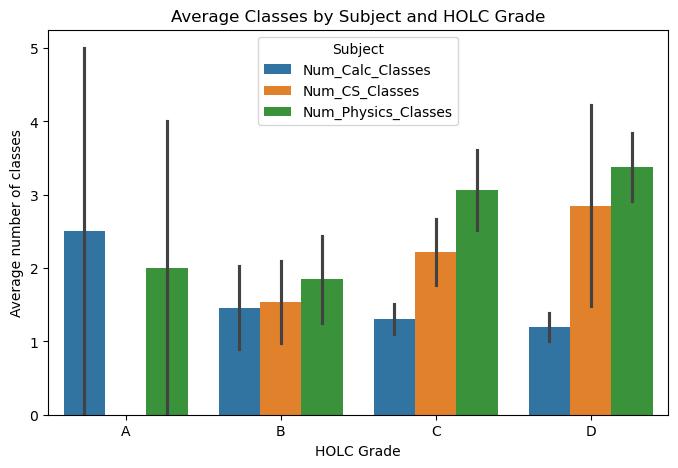

In [5]:
# Baseline regression: Predict Total_Adv_STEM using HOLC grade only (as ordered categorical) via OLS.
# Then produce visualizations: mosaic/stacked bar, bar/point by grade, distributions, and scatter with jitter.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Use existing la_df in memory

# Simple baseline: encode grade as ordered categorical with integer codes for OLS
reg_df = la_df.copy()
reg_df = reg_df.dropna(subset=['grade'])
reg_df['grade_code'] = reg_df['grade'].cat.codes  # A=0, B=1, C=2, D=3

# OLS with intercept: Total_Adv_STEM ~ grade_code
model = smf.ols('Total_Adv_STEM ~ grade_code', data=reg_df).fit(cov_type='HC1')
print(model.summary())

# Stacked bar chart: fraction of schools with Has_Calc/CS/Physics by grade
flag_map = {'Yes': 1, 'No': 0}
flag_df = la_df.copy()
for col in ['Has_Calc','Has_CS','Has_Physics']:
    flag_df[col] = flag_df[col].map(flag_map)

share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


plt.figure(figsize=(8,5))
plot_df = la_df.melt(id_vars='grade', value_vars=['Num_Calc_Classes','Num_CS_Classes','Num_Physics_Classes'], var_name='Subject', value_name='Classes')
sns.barplot(data=plot_df, x='grade', y='Classes', hue='Subject', estimator=np.mean, errorbar='se')
plt.title('Average Classes by Subject and HOLC Grade')
plt.ylabel('Average number of classes')
plt.xlabel('HOLC Grade')
plt.legend(title='Subject')
plt.show()

## Chicago Regressions

In [16]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# =========================
# 1. LOAD DATA
# =========================

chi_file = "All_Classes_HS_Chicago.csv"
chi_schools = pd.read_csv(chi_file, dtype=str)

nat_file = "National_Schools_with_AdvancedSTEM_Expanded.csv"
nat = pd.read_csv(nat_file, dtype=str)

chi_schools["NCESSCH"] = chi_schools["NCESSCH"].astype(str)
nat["NCESSCH"] = nat["NCESSCH"].astype(str)

# =========================
# 2. MERGE INTO NATIONAL DATA
# =========================

chi_ids = chi_schools[["NCESSCH"]].drop_duplicates()
df = chi_ids.merge(nat, on="NCESSCH", how="left")

print(f"Chicago matched schools: {len(df)}")

# =========================
# 3. CLEAN HOLC GRADE
# =========================

df["grade"] = df["grade"].astype(str).str.strip().str.upper()
valid_grades = ["A", "B", "C", "D"]
df = df[df["grade"].isin(valid_grades)].copy()

df["grade_cat"] = pd.Categorical(df["grade"], categories=["A", "B", "C", "D"], ordered=True)
df["Redline_CD"] = df["grade"].isin(["C", "D"]).astype(int)

# =========================
# 4. STEM VARIABLES
# =========================

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

df["Has_Calc_bin"] = df["Has_Calc"].map({"Yes":1, "No":0})
df["Has_CS_bin"] = df["Has_CS"].map({"Yes":1, "No":0})
df["Has_Physics_bin"] = df["Has_Physics"].map({"Yes":1, "No":0})

df["Any_STEM"] = (
    df["Has_Calc_bin"] | df["Has_CS_bin"] | df["Has_Physics_bin"]
).astype(int)

df["Total_STEM_Classes"] = (
      df["Num_Calc_Classes"]
    + df["Num_CS_Classes"]
    + df["Num_Physics_Classes"]
)

# =========================
# 5. ROBUSTLY HANDLE CONTROL VARIABLES
# =========================

control_vars = ["MAGNET_FLAG", "CHARTER_FLAG", "TITLE1_FLAG", "PCT_CERTIFIED_FTE"]

# Check which controls are missing
missing_controls = [c for c in control_vars if c not in df.columns]
if missing_controls:
    print("The following control variables were missing and will be created as 0:", missing_controls)

# Create missing controls with safe defaults
for col in missing_controls:
    df[col] = 0

# Convert flags to 0/1 safely
def make_flag(col):
    return col.astype(str).str.upper().map(
        {"YES":1, "NO":0, "1":1, "0":0}
    ).fillna(0).astype(int)

df["MAGNET_FLAG"] = make_flag(df["MAGNET_FLAG"])
df["CHARTER_FLAG"] = make_flag(df["CHARTER_FLAG"])
df["TITLE1_FLAG"] = make_flag(df["TITLE1_FLAG"])

# Handle certified teacher %
df["PCT_CERTIFIED_FTE"] = pd.to_numeric(df["PCT_CERTIFIED_FTE"], errors="coerce").fillna(0)

reg_df = df.dropna(subset=["Any_STEM", "Total_STEM_Classes"])
print("Final Chicago sample:", len(reg_df))

# =========================
# 6. Regression Helper (HC3 robust)
# =========================

def run_lpm(formula, name):
    model = smf.ols(formula, data=reg_df)
    res = model.fit(cov_type="HC3")
    print("\n=====", name, "=====")
    print(res.summary())

    return pd.DataFrame({
        "term":res.params.index,
        "coef":res.params.values,
        "std_err":res.bse.values,
        "t":res.tvalues.values,
        "p":res.pvalues.values,
        "model":name
    })

# =========================
# 7. Run Chicago Regressions
# =========================

results = []

formulas = {
    "CHI_LPM_AnySTEM_BinaryRedline": """
        Any_STEM ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "CHI_LPM_AnySTEM_GradeCat": """
        Any_STEM ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "CHI_LPM_TotalSTEM_BinaryRedline": """
        Total_STEM_Classes ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "CHI_LPM_TotalSTEM_GradeCat": """
        Total_STEM_Classes ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """
}

for name, formula in formulas.items():
    results.append(run_lpm(formula, name))

final = pd.concat(results, ignore_index=True)
final.to_csv("Chicago_Regression_Results_LPM.csv", index=False)

print("\nSaved Chicago_Regression_Results_LPM.csv")


Chicago matched schools: 113
The following control variables were missing and will be created as 0: ['MAGNET_FLAG', 'CHARTER_FLAG']
Final Chicago sample: 111

===== CHI_LPM_AnySTEM_BinaryRedline =====
                            OLS Regression Results                            
Dep. Variable:               Any_STEM   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                     9.741
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           0.000129
Time:                        18:01:01   Log-Likelihood:                -43.374
No. Observations:                 111   AIC:                             92.75
Df Residuals:                     108   BIC:                             100.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
         

/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anacond

                            OLS Regression Results                            
Dep. Variable:         Total_Adv_STEM   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6115
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.436
Time:                        17:12:36   Log-Likelihood:                -434.53
No. Observations:                 111   AIC:                             873.1
Df Residuals:                     109   BIC:                             878.5
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3026      5.114      2.797      0.0

/var/folders/hz/d49rtbh904s9fy8xy2xyj8m40000gn/T/ipykernel_8246/300213310.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


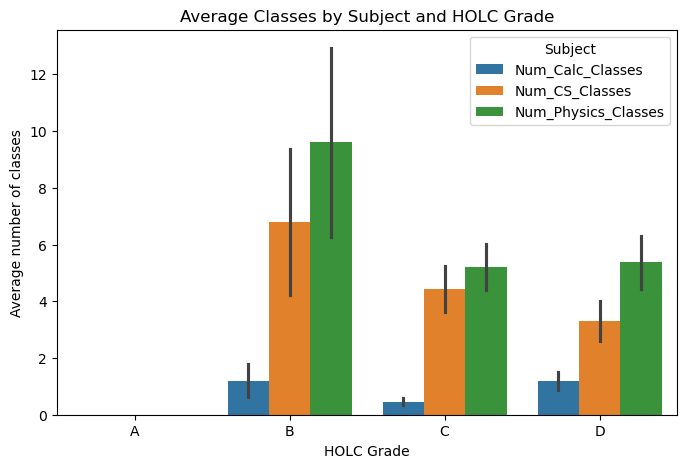

In [7]:
# Baseline regression: Predict Total_Adv_STEM using HOLC grade only (as ordered categorical) via OLS.
# Then produce visualizations: mosaic/stacked bar, bar/point by grade, distributions, and scatter with jitter.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Use existing la_df in memory

# Simple baseline: encode grade as ordered categorical with integer codes for OLS
reg_df = la_df.copy()
reg_df = reg_df.dropna(subset=['grade'])
reg_df['grade_code'] = reg_df['grade'].cat.codes  # A=0, B=1, C=2, D=3

# OLS with intercept: Total_Adv_STEM ~ grade_code
model = smf.ols('Total_Adv_STEM ~ grade_code', data=reg_df).fit(cov_type='HC1')
print(model.summary())

# Stacked bar chart: fraction of schools with Has_Calc/CS/Physics by grade
flag_map = {'Yes': 1, 'No': 0}
flag_df = la_df.copy()
for col in ['Has_Calc','Has_CS','Has_Physics']:
    flag_df[col] = flag_df[col].map(flag_map)

share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


plt.figure(figsize=(8,5))
plot_df = la_df.melt(id_vars='grade', value_vars=['Num_Calc_Classes','Num_CS_Classes','Num_Physics_Classes'], var_name='Subject', value_name='Classes')
sns.barplot(data=plot_df, x='grade', y='Classes', hue='Subject', estimator=np.mean, errorbar='se')
plt.title('Average Classes by Subject and HOLC Grade')
plt.ylabel('Average number of classes')
plt.xlabel('HOLC Grade')
plt.legend(title='Subject')
plt.show()

## Detroit Regressions

In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# =========================
# 1. LOAD DATA
# =========================

det_file = "Detroit_Schools_with_AdvancedSTEM.csv"
det_schools = pd.read_csv(det_file, dtype=str)

nat = pd.read_csv("National_Schools_with_AdvancedSTEM_Expanded.csv", dtype=str)

det_schools["NCESSCH"] = det_schools["NCESSCH"].astype(str)
nat["NCESSCH"] = nat["NCESSCH"].astype(str)

# =========================
# 2. MERGE INTO NATIONAL DATA
# =========================

det_ids = det_schools[["NCESSCH"]].drop_duplicates()
df = det_ids.merge(nat, on="NCESSCH", how="left")

print("Detroit matched schools:", len(df))

# =========================
# 3. CLEAN HOLC GRADE
# =========================

df["grade"] = df["grade"].astype(str).str.strip().str.upper()
valid_grades = ["A", "B", "C", "D"]
df = df[df["grade"].isin(valid_grades)].copy()

df["grade_cat"] = pd.Categorical(df["grade"], categories=["A", "B", "C", "D"], ordered=True)
df["Redline_CD"] = df["grade"].isin(["C", "D"]).astype(int)

# =========================
# 4. STEM VARIABLES
# =========================

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

df["Has_Calc_bin"] = df["Has_Calc"].map({"Yes":1,"No":0})
df["Has_CS_bin"] = df["Has_CS"].map({"Yes":1,"No":0})
df["Has_Physics_bin"] = df["Has_Physics"].map({"Yes":1,"No":0})

df["Any_STEM"] = (
    df["Has_Calc_bin"] | df["Has_CS_bin"] | df["Has_Physics_bin"]
).astype(int)

df["Total_STEM_Classes"] = (
    df["Num_Calc_Classes"] +
    df["Num_CS_Classes"] +
    df["Num_Physics_Classes"]
)

# =========================
# 5. ROBUSTLY HANDLE CONTROL VARIABLES
# =========================

control_vars = ["MAGNET_FLAG", "CHARTER_FLAG", "TITLE1_FLAG", "PCT_CERTIFIED_FTE"]

# Identify missing ones
missing_controls = [c for c in control_vars if c not in df.columns]
if missing_controls:
    print("Missing controls (created as 0):", missing_controls)

# Create missing controls
for col in missing_controls:
    df[col] = 0

# Clean flag-like columns
def make_flag(col):
    return col.astype(str).str.upper().map(
        {"YES":1, "NO":0, "1":1, "0":0}
    ).fillna(0).astype(int)

df["MAGNET_FLAG"] = make_flag(df["MAGNET_FLAG"])
df["CHARTER_FLAG"] = make_flag(df["CHARTER_FLAG"])
df["TITLE1_FLAG"] = make_flag(df["TITLE1_FLAG"])

df["PCT_CERTIFIED_FTE"] = pd.to_numeric(df["PCT_CERTIFIED_FTE"], errors="coerce").fillna(0)

reg_df = df.dropna(subset=["Any_STEM", "Total_STEM_Classes"])
print("Final Detroit sample:", len(reg_df))

# =========================
# 6. Regression Helper (HC3 robust)
# =========================

def run_lpm(formula, name):
    model = smf.ols(formula, data=reg_df)
    res = model.fit(cov_type="HC3")
    print("\n=====", name, "=====")
    print(res.summary())
    return pd.DataFrame({
        "term":res.params.index,
        "coef":res.params.values,
        "std_err":res.bse.values,
        "t":res.tvalues.values,
        "p":res.pvalues.values,
        "model":name
    })

# =========================
# 7. Run Detroit Regressions
# =========================

results = []
formulas = {
    "DET_LPM_AnySTEM_BinaryRedline": """
        Any_STEM ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "DET_LPM_AnySTEM_GradeCat": """
        Any_STEM ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "DET_LPM_TotalSTEM_BinaryRedline": """
        Total_STEM_Classes ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "DET_LPM_TotalSTEM_GradeCat": """
        Total_STEM_Classes ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """
}

for name, formula in formulas.items():
    results.append(run_lpm(formula, name))

final = pd.concat(results, ignore_index=True)
final.to_csv("Detroit_Regression_Results_LPM.csv", index=False)

print("\nSaved Detroit_Regression_Results_LPM.csv")


Detroit matched schools: 85
Missing controls (created as 0): ['MAGNET_FLAG', 'CHARTER_FLAG']
Final Detroit sample: 85

===== DET_LPM_AnySTEM_BinaryRedline =====
                            OLS Regression Results                            
Dep. Variable:               Any_STEM   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     16.26
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           1.13e-06
Time:                        18:01:19   Log-Likelihood:                -51.076
No. Observations:                  85   AIC:                             108.2
Df Residuals:                      82   BIC:                             115.5
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          

/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anacond

                            OLS Regression Results                            
Dep. Variable:         Total_Adv_STEM   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     12.01
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           0.000840
Time:                        17:18:28   Log-Likelihood:                -347.25
No. Observations:                  85   AIC:                             698.5
Df Residuals:                      83   BIC:                             703.4
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.3675      6.970      4.357      0.0

/var/folders/hz/d49rtbh904s9fy8xy2xyj8m40000gn/T/ipykernel_8246/3365745511.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


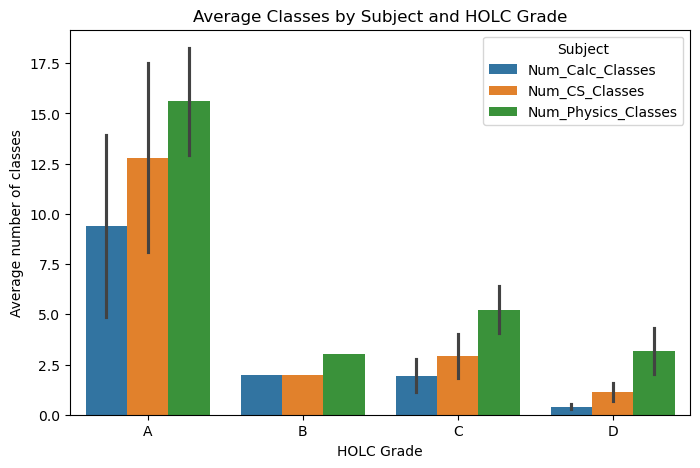

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Use existing la_df in memory

# Simple baseline: encode grade as ordered categorical with integer codes for OLS
reg_df = la_df.copy()
reg_df = reg_df.dropna(subset=['grade'])
reg_df['grade_code'] = reg_df['grade'].cat.codes  # A=0, B=1, C=2, D=3

# OLS with intercept: Total_Adv_STEM ~ grade_code
model = smf.ols('Total_Adv_STEM ~ grade_code', data=reg_df).fit(cov_type='HC1')
print(model.summary())

# Stacked bar chart: fraction of schools with Has_Calc/CS/Physics by grade
flag_map = {'Yes': 1, 'No': 0}
flag_df = la_df.copy()
for col in ['Has_Calc','Has_CS','Has_Physics']:
    flag_df[col] = flag_df[col].map(flag_map)

share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


plt.figure(figsize=(8,5))
plot_df = la_df.melt(id_vars='grade', value_vars=['Num_Calc_Classes','Num_CS_Classes','Num_Physics_Classes'], var_name='Subject', value_name='Classes')
sns.barplot(data=plot_df, x='grade', y='Classes', hue='Subject', estimator=np.mean, errorbar='se')
plt.title('Average Classes by Subject and HOLC Grade')
plt.ylabel('Average number of classes')
plt.xlabel('HOLC Grade')
plt.legend(title='Subject')
plt.show()

## Philly Regressions

In [18]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# =========================
# 1. LOAD DATA
# =========================

phl_file = "Philly_Schools_with_AdvancedSTEM.csv"
phl_schools = pd.read_csv(phl_file, dtype=str)

nat = pd.read_csv("National_Schools_with_AdvancedSTEM_Expanded.csv", dtype=str)

phl_schools["NCESSCH"] = phl_schools["NCESSCH"].astype(str)
nat["NCESSCH"] = nat["NCESSCH"].astype(str)

# =========================
# 2. MERGE INTO NATIONAL DATA
# =========================

phl_ids = phl_schools[["NCESSCH"]].drop_duplicates()
df = phl_ids.merge(nat, on="NCESSCH", how="left")

print("Philadelphia matched:", len(df))

# =========================
# 3. CLEAN HOLC GRADE
# =========================

df["grade"] = df["grade"].astype(str).str.strip().str.upper()
df = df[df["grade"].isin(["A","B","C","D"])].copy()

df["grade_cat"] = pd.Categorical(
    df["grade"],
    categories=["A","B","C","D"],
    ordered=True
)
df["Redline_CD"] = df["grade"].isin(["C","D"]).astype(int)

# =========================
# 4. STEM VARIABLES
# =========================

for col in ["Num_Calc_Classes","Num_CS_Classes","Num_Physics_Classes"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

df["Has_Calc_bin"]    = df["Has_Calc"].map({"Yes":1,"No":0})
df["Has_CS_bin"]      = df["Has_CS"].map({"Yes":1,"No":0})
df["Has_Physics_bin"] = df["Has_Physics"].map({"Yes":1,"No":0})

df["Any_STEM"] = (
    df["Has_Calc_bin"] | df["Has_CS_bin"] | df["Has_Physics_bin"]
).astype(int)

df["Total_STEM_Classes"] = (
    df["Num_Calc_Classes"] +
    df["Num_CS_Classes"] +
    df["Num_Physics_Classes"]
)

# =========================
# 5. ROBUSTLY HANDLE CONTROLS
# =========================

control_vars = ["MAGNET_FLAG", "CHARTER_FLAG", "TITLE1_FLAG", "PCT_CERTIFIED_FTE"]

missing_controls = [c for c in control_vars if c not in df.columns]
if missing_controls:
    print("Missing controls (created as 0):", missing_controls)

for col in missing_controls:
    df[col] = 0

def make_flag(col):
    return col.astype(str).str.upper().map(
        {"YES":1,"NO":0,"1":1,"0":0}
    ).fillna(0).astype(int)

df["MAGNET_FLAG"]  = make_flag(df["MAGNET_FLAG"])
df["CHARTER_FLAG"] = make_flag(df["CHARTER_FLAG"])
df["TITLE1_FLAG"]  = make_flag(df["TITLE1_FLAG"])

df["PCT_CERTIFIED_FTE"] = pd.to_numeric(df["PCT_CERTIFIED_FTE"], errors="coerce").fillna(0)

reg_df = df.dropna(subset=["Any_STEM","Total_STEM_Classes"])
print("Final Philadelphia sample:", len(reg_df))

# =========================
# 6. Robust Regression Helper
# =========================

def run_lpm(formula, name):
    res = smf.ols(formula, data=reg_df).fit(cov_type="HC3")
    print("\n=====", name, "=====")
    print(res.summary())
    return pd.DataFrame({
        "term":res.params.index,
        "coef":res.params.values,
        "std_err":res.bse.values,
        "t":res.tvalues.values,
        "p":res.pvalues.values,
        "model":name
    })

# =========================
# 7. Run Philadelphia Regressions
# =========================

results = []

formulas = {
    "PHL_LPM_AnySTEM_BinaryRedline": """
        Any_STEM ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "PHL_LPM_AnySTEM_GradeCat": """
        Any_STEM ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "PHL_LPM_TotalSTEM_BinaryRedline": """
        Total_STEM_Classes ~ Redline_CD + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """,
    "PHL_LPM_TotalSTEM_GradeCat": """
        Total_STEM_Classes ~ C(grade_cat, Treatment('A')) + MAGNET_FLAG + CHARTER_FLAG + PCT_CERTIFIED_FTE + TITLE1_FLAG
    """
}

for name, formula in formulas.items():
    results.append(run_lpm(formula, name))

final = pd.concat(results, ignore_index=True)
final.to_csv("Philly_Regression_Results_LPM.csv", index=False)

print("\nSaved Philly_Regression_Results_LPM.csv")


Philadelphia matched: 65
Missing controls (created as 0): ['MAGNET_FLAG', 'CHARTER_FLAG']
Final Philadelphia sample: 65

===== PHL_LPM_AnySTEM_BinaryRedline =====
                            OLS Regression Results                            
Dep. Variable:               Any_STEM   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.3529
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.704
Time:                        18:02:02   Log-Likelihood:                -30.073
No. Observations:                  65   AIC:                             66.15
Df Residuals:                      62   BIC:                             72.67
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err        

/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/zoechan/opt/anaconda3/envs/geo/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/zoechan/opt/anacond

                            OLS Regression Results                            
Dep. Variable:         Total_Adv_STEM   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4924
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.485
Time:                        17:19:29   Log-Likelihood:                -225.79
No. Observations:                  65   AIC:                             455.6
Df Residuals:                      63   BIC:                             459.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2261      3.620      2.548      0.0

/var/folders/hz/d49rtbh904s9fy8xy2xyj8m40000gn/T/ipykernel_8246/3365745511.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


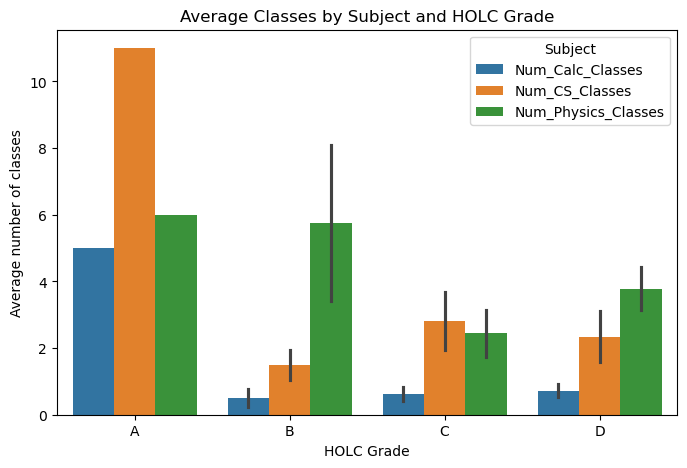

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Use existing la_df in memory

# Simple baseline: encode grade as ordered categorical with integer codes for OLS
reg_df = la_df.copy()
reg_df = reg_df.dropna(subset=['grade'])
reg_df['grade_code'] = reg_df['grade'].cat.codes  # A=0, B=1, C=2, D=3

# OLS with intercept: Total_Adv_STEM ~ grade_code
model = smf.ols('Total_Adv_STEM ~ grade_code', data=reg_df).fit(cov_type='HC1')
print(model.summary())

# Stacked bar chart: fraction of schools with Has_Calc/CS/Physics by grade
flag_map = {'Yes': 1, 'No': 0}
flag_df = la_df.copy()
for col in ['Has_Calc','Has_CS','Has_Physics']:
    flag_df[col] = flag_df[col].map(flag_map)

share_by_grade = flag_df.groupby('grade')[['Has_Calc','Has_CS','Has_Physics']].mean().reindex(['A','B','C','D'])


plt.figure(figsize=(8,5))
plot_df = la_df.melt(id_vars='grade', value_vars=['Num_Calc_Classes','Num_CS_Classes','Num_Physics_Classes'], var_name='Subject', value_name='Classes')
sns.barplot(data=plot_df, x='grade', y='Classes', hue='Subject', estimator=np.mean, errorbar='se')
plt.title('Average Classes by Subject and HOLC Grade')
plt.ylabel('Average number of classes')
plt.xlabel('HOLC Grade')
plt.legend(title='Subject')
plt.show()

# Summary Data

In [21]:
import pandas as pd
import os

# ===============================
# File mapping for each city
# ===============================
files = {
    "Chicago": "Chicago_Regression_Results_LPM.csv",
    "Detroit": "Detroit_Regression_Results_LPM.csv",
    "LA": "LA_Regression_Results_LPM.csv",
    "Philly": "Philly_Regression_Results_LPM.csv"
}

# ===============================
# Correct regression model prefixes
# (The issue was here — now fixed)
# ===============================
prefix_map = {
    "Chicago": "CHI",
    "Detroit": "DET",
    "LA": "LA",
    "Philly": "PHL"
}

# ===============================
# Create output folder
# ===============================
out_dir = "Unified_Summaries"
os.makedirs(out_dir, exist_ok=True)

# ===============================
# Helper function to extract coefficients
# ===============================
def get_coef(df, model_name, term):
    """Return coefficient for a given model + term (or None)."""
    subset = df[(df["model"] == model_name) & (df["term"] == term)]
    if len(subset) == 0:
        return None
    return float(subset["coef"].iloc[0])

# Load regression CSVs
city_dfs = {city: pd.read_csv(path) for city, path in files.items()}

# ===============================
# === Table A: Binary Redline Effects ===
# ===============================
tableA = []

for city, df in city_dfs.items():
    prefix = prefix_map[city]

    anystem = get_coef(df, f"{prefix}_LPM_AnySTEM_BinaryRedline", "Redline_CD")
    totalstem = get_coef(df, f"{prefix}_LPM_TotalSTEM_BinaryRedline", "Redline_CD")

    tableA.append({
        "City": city,
        "Binary Redline Effect (Any STEM)": anystem,
        "Binary Redline Effect (Total STEM)": totalstem
    })

tableA = pd.DataFrame(tableA)
tableA.to_csv(os.path.join(out_dir, "TableA_BinaryRedline.csv"), index=False)
tableA.to_markdown(os.path.join(out_dir, "TableA_BinaryRedline.md"), index=False)

# ===============================
# === Table B: Grade Categories (B/C/D compared to A) ===
# ===============================
grade_terms = [
    "C(grade_cat, Treatment('A'))[T.B]",
    "C(grade_cat, Treatment('A'))[T.C]",
    "C(grade_cat, Treatment('A'))[T.D]"
]

tableB = []

for city, df in city_dfs.items():
    prefix = prefix_map[city]
    row = {"City": city}

    # AnySTEM
    model_any = f"{prefix}_LPM_AnySTEM_GradeCat"
    row["AnySTEM_B"] = get_coef(df, model_any, grade_terms[0])
    row["AnySTEM_C"] = get_coef(df, model_any, grade_terms[1])
    row["AnySTEM_D"] = get_coef(df, model_any, grade_terms[2])

    # TotalSTEM
    model_tot = f"{prefix}_LPM_TotalSTEM_GradeCat"
    row["TotalSTEM_B"] = get_coef(df, model_tot, grade_terms[0])
    row["TotalSTEM_C"] = get_coef(df, model_tot, grade_terms[1])
    row["TotalSTEM_D"] = get_coef(df, model_tot, grade_terms[2])

    tableB.append(row)

tableB = pd.DataFrame(tableB)
tableB.to_csv(os.path.join(out_dir, "TableB_GradeCategories.csv"), index=False)
tableB.to_markdown(os.path.join(out_dir, "TableB_GradeCategories.md"), index=False)

# ===============================
# === Table C: Control Variables ===
# ===============================
controls = ["MAGNET_FLAG", "CHARTER_FLAG", "PCT_CERTIFIED_FTE", "TITLE1_FLAG"]

tableC = []

for city, df in city_dfs.items():
    prefix = prefix_map[city]
    model_bin = f"{prefix}_LPM_AnySTEM_BinaryRedline"

    row = {"City": city}
    for ctrl in controls:
        row[ctrl] = get_coef(df, model_bin, ctrl)

    tableC.append(row)

tableC = pd.DataFrame(tableC)
tableC.to_csv(os.path.join(out_dir, "TableC_Controls.csv"), index=False)
tableC.to_markdown(os.path.join(out_dir, "TableC_Controls.md"), index=False)

print("\n✅ Unified summary tables created successfully!")
print(f"📁 Saved in folder: {os.path.abspath(out_dir)}")



✅ Unified summary tables created successfully!
📁 Saved in folder: /Users/zoechan/Documents/GitHub/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/Unified_Summaries
